Bayesian Deep Learning:
Now that you have implemented GP classification, consider the more general case of training a deep neural network.
The loss function of a DNN is not a quadratic, but now that we have already approximated the likelihood with a quadratic, 
we might as well do so for the prior, too. Train a DNN (architecture provided in the notebook) with SGD (or Adam), then construct a Laplace approximation to the weights, using the Hessian of the entire loss function (implementing this Hessian manually would be tedious. Thankfully, there are software packages available that provide this object for you). Sample a set of weights from this approximate posterior and, for a set of test points, plot the corresponding predictive probabilities for the two classes.

In [1]:
#import all relevant packages
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from torch.nn import functional as F

np.random.seed(42)
torch.manual_seed(42)

# Data wrangling
Similar to the last homework we take the first two classes of fashionMNIST and train a binary classifier. Everything has already been prepared for you. There is no need to change anything.

In [2]:
# data wrangling: get the first two classes for FMNIST
FMNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])


FMNIST_train = torchvision.datasets.FashionMNIST(
        '~/data/fmnist',
        train=True,
        download=False,
        transform=FMNIST_transform)


FMNIST_test = torchvision.datasets.FashionMNIST(
        '~/data/fmnist',
        train=False,
        download=False,
        transform=FMNIST_transform)

def get_subset_FMNIST(classes=[0,1], dataset=FMNIST_train):
    
    dataset.targets = dataset.targets.clone().detach()
    idx = torch.zeros(dataset.targets.size()).byte()
    for c in classes:
        idx += (dataset.targets==c).byte()
    dataset.targets= dataset.targets[idx]
    dataset.data = dataset.data[idx.numpy().astype(np.bool)]
    
    #remap all classes to list of ints starting at 1
    map_dict = dict()
    for i, c in enumerate(classes):
        map_dict[c] = i
    
    for i, t in enumerate(dataset.targets):
        dataset.targets[i] = map_dict[t.item()]
    
    return(dataset.data, dataset.targets)

classes = [0,1]
FMNIST_train.data, FMNIST_train.targets = get_subset_FMNIST(classes=classes, dataset=FMNIST_train)
FMNIST_test.data, FMNIST_test.targets = get_subset_FMNIST(classes=classes, dataset=FMNIST_test)
print(len(FMNIST_train.targets))
print(FMNIST_train.targets[:10])
print(len(FMNIST_test.targets))
print(FMNIST_test.targets[:10])

12000
tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 1])
2000
tensor([1, 1, 1, 1, 0, 1, 0, 0, 1, 1])


/opt/conda/conda-bld/pytorch_1579040055865/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/opt/conda/conda-bld/pytorch_1579040055865/work/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


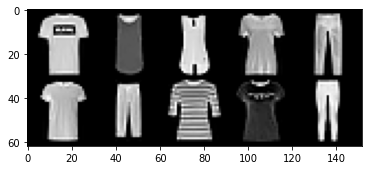

In [3]:
# have a look at them to verify they are only 
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

images = FMNIST_train.data[:10].view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(images, nrow=5))

In [4]:
fmnist_train_loader = torch.utils.data.dataloader.DataLoader(
    FMNIST_train,
    batch_size=128,
    shuffle=True
)

fmnist_test_loader = torch.utils.data.dataloader.DataLoader(
    FMNIST_test,
    batch_size=128,
    shuffle=False,
)


# Training routine
- We prepared a network for you. You can change it if you desire but this one works perfectly fine for our task. If you change the network remember to use torch.nn.Sequential because the BackPACK package only works with this way of creating networks. 
- We already prepared an optimizer for you. Again, you can play around with the parameters and test other optimizers but just using the suggestion is sufficient. 
- Your first task is to write the training loop for the model
- Make sure to check that the training was successful

In [5]:
#set up the network
def NN(num_classes=2, num_LL=256):
    
    features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(32, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Flatten(),
        torch.nn.Linear(4 * 4 * 32, num_LL), 
        torch.nn.Linear(num_LL, num_classes)
    )
    return(features)

In [6]:
#set up the training routine
fmnist_model = NN(num_classes=2)
loss_function = torch.nn.CrossEntropyLoss()

fmnist_train_optimizer = torch.optim.Adam(fmnist_model.parameters(), lr=1e-3, weight_decay=5e-4)
#dont use SGD, it is way worse than Adam here
FMNIST_PATH = "models/FMNIST_2classes_256.pth"

In [7]:
# write the training routine:

def train(net, data_loader, optimizer, loss, metric, device, epochs=10):
    losses = []
    metrics = []
    net.to(device)
    net.train()
    for epoch in range(epochs):
        for x_train, y_train in data_loader:
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            pred = net(x_train)
            l = loss(pred, y_train)
            m = metric(pred, y_train)
            losses.append(l)
            metrics.append(m)
            
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        print(f'Epoch: {epoch+1} loss: {l} {metric.__name__}: {m}')

def test(net, data_loader, loss, metric, device):
    net.to(device)
    net.eval()
    l = [] 
    m = []
    for x_test, y_test in data_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        with torch.no_grad():
            pred = net(x_test)
            l.append(loss(pred, y_test))
            m.append(metric(pred, y_test))
    
    print(f'{metric.__name__}: {sum(m)/len(m)} loss: {sum(l)/len(l)}')

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [8]:
train(fmnist_model, fmnist_train_loader, fmnist_train_optimizer, loss_function,
      accuracy, device='cuda', epochs=10)

Epoch: 1 loss: 0.043945979326963425 accuracy: 0.9895833730697632
Epoch: 2 loss: 0.0565909743309021 accuracy: 0.9791666865348816
Epoch: 3 loss: 0.004080450627952814 accuracy: 1.0
Epoch: 4 loss: 0.002394629642367363 accuracy: 1.0
Epoch: 5 loss: 0.005584552884101868 accuracy: 1.0
Epoch: 6 loss: 0.03454991802573204 accuracy: 0.9895833730697632
Epoch: 7 loss: 0.029766425490379333 accuracy: 0.9895833730697632
Epoch: 8 loss: 0.006926551926881075 accuracy: 1.0
Epoch: 9 loss: 0.001936157583259046 accuracy: 1.0
Epoch: 10 loss: 0.008418912999331951 accuracy: 1.0


In [9]:
test(fmnist_model, fmnist_test_loader, loss_function, accuracy, device='cuda')

accuracy: 0.996289074420929 loss: 0.010877386666834354


# Laplace approximation of the weights
- Use the BackPACK package to approximate the Hessian of the parameters. Especially look at the DiagHessian() method.
- Hints:
    1. Do one iteration over the entire training set and use the mean of the Hessian of the mini-batches as the best approximation of the Hessian. 
    2. Do not forget to add the prior variance to your Hessian. The precision is 1 over the variance. Use a prior precision of 10, 20, and 50 (or variance of 1/10, 1/20, 1/50). 

In [10]:
# Approximate the Hessian
def Hessian(net, data_loader, loss, prec, device):
    H = np.array([torch.zeros_like(p) for p in net.parameters()])
    net.to(device)
    with backpack(DiagHessian()):
        extend(net)
        extend(loss)
        i = 0
        for x_train, y_train in data_loader:
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            pred = net(x_train)
            l = loss(pred, y_train)
            l.backward()
            # adding precision cuz we will invert Hessian outside 
            H += np.array([p.diag_h + prec for p in net.parameters()])
            i += 1
            net.zero_grad()
        H /= i

    return H

In [11]:
# calculate the weights for prior precision of 10, 20 and 50

hess10 = Hessian(fmnist_model, fmnist_train_loader, loss_function, prec=10, device='cuda')
hess20 = Hessian(fmnist_model, fmnist_train_loader, loss_function, prec=20, device='cuda')
hess50 = Hessian(fmnist_model, fmnist_train_loader, loss_function, prec=50, device='cuda')

# Plot the results
- We take the first ten datapoints from the test dataset.
- Draw 100 samples from the weight distribution do a forward pass for each and plot the resulting predictions.
- Repeat this procedure for prior precision 10, 20 and 50 (or variance of 1/10, 1/20, 1/50).
- Hint: We assume a diagonal Hessian, i.e. we assume independence between the weights. Do not try to model it as a multivariate Gaussian with diagonal Covariance since in will not fit into memory. How can you use independence to solve this problem?

In [12]:
#get the first ten datapoints from the test set
fmnist_test_loader = torch.utils.data.dataloader.DataLoader(
    FMNIST_test,
    batch_size=10,
    shuffle=False,
)

test_10_X, test_10_y = next(iter(fmnist_test_loader))
print(test_10_X.size(), test_10_y.size())
print(test_10_y)

torch.Size([10, 1, 28, 28]) torch.Size([10])
tensor([1, 1, 1, 1, 0, 1, 0, 0, 1, 1])


In [13]:
def sample(net, hess, n_samp):
    return [Normal(p, torch.sqrt(1/H)).sample((n_samp,)) 
            for p, H in zip(net.parameters(), hess)]

def pivot(w):
    n = w[0].shape[0]
    return [[weigh[i] for weigh in w] for i in range(n)]

def predict(net, weights, data):
    P = []
    names = [p for p in net.state_dict()]

    for ws in weights:
        wp = pivot(ws)
        preds = []
        with torch.no_grad():
            for w in wp:
                dic = dict(zip(names, w))
                net.load_state_dict(dic)
                pred = F.softmax(net(data), dim=-1)[:,0]
                preds.append(pred.cpu().numpy())
            P.append(preds)

    return P

def plot(predictions):
    for pl in predictions:
        pl = np.array(pl)
        print(f'Prediction std: {pl.std(axis=0)}')
        figs, axes = plt.subplots(5, 2, figsize=(20,20))
        for i, ax in enumerate(axes):
            ax[0].plot(np.arange(100), pl[:,2*i])
            ax[1].plot(np.arange(100), pl[:,2*i+1])
        plt.show()

In [14]:
#take 100 samples from the distribution over the weights. 
W = [sample(fmnist_model, hess, n_samp=100) for hess in [hess10, hess20, hess50]]

Prediction std: [0.49342397 0.49707285 0.49547595 0.49327222 0.48691368 0.49832466
 0.49412084 0.47073707 0.49342433 0.4993167 ]


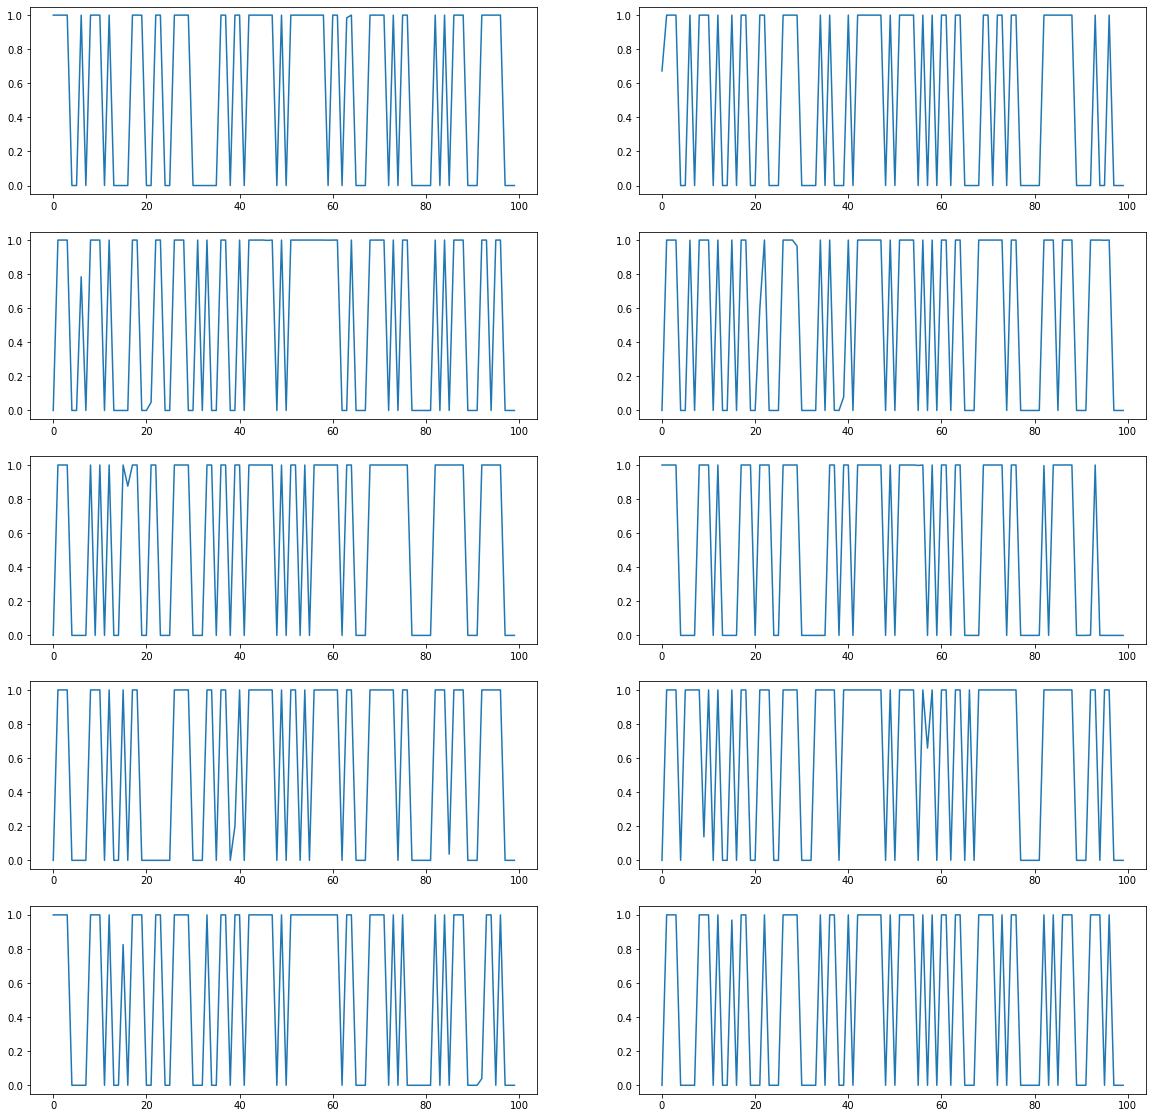

Prediction std: [0.4929273  0.4939474  0.4994089  0.48595193 0.47530317 0.4945494
 0.49867532 0.4836747  0.49582788 0.4940834 ]


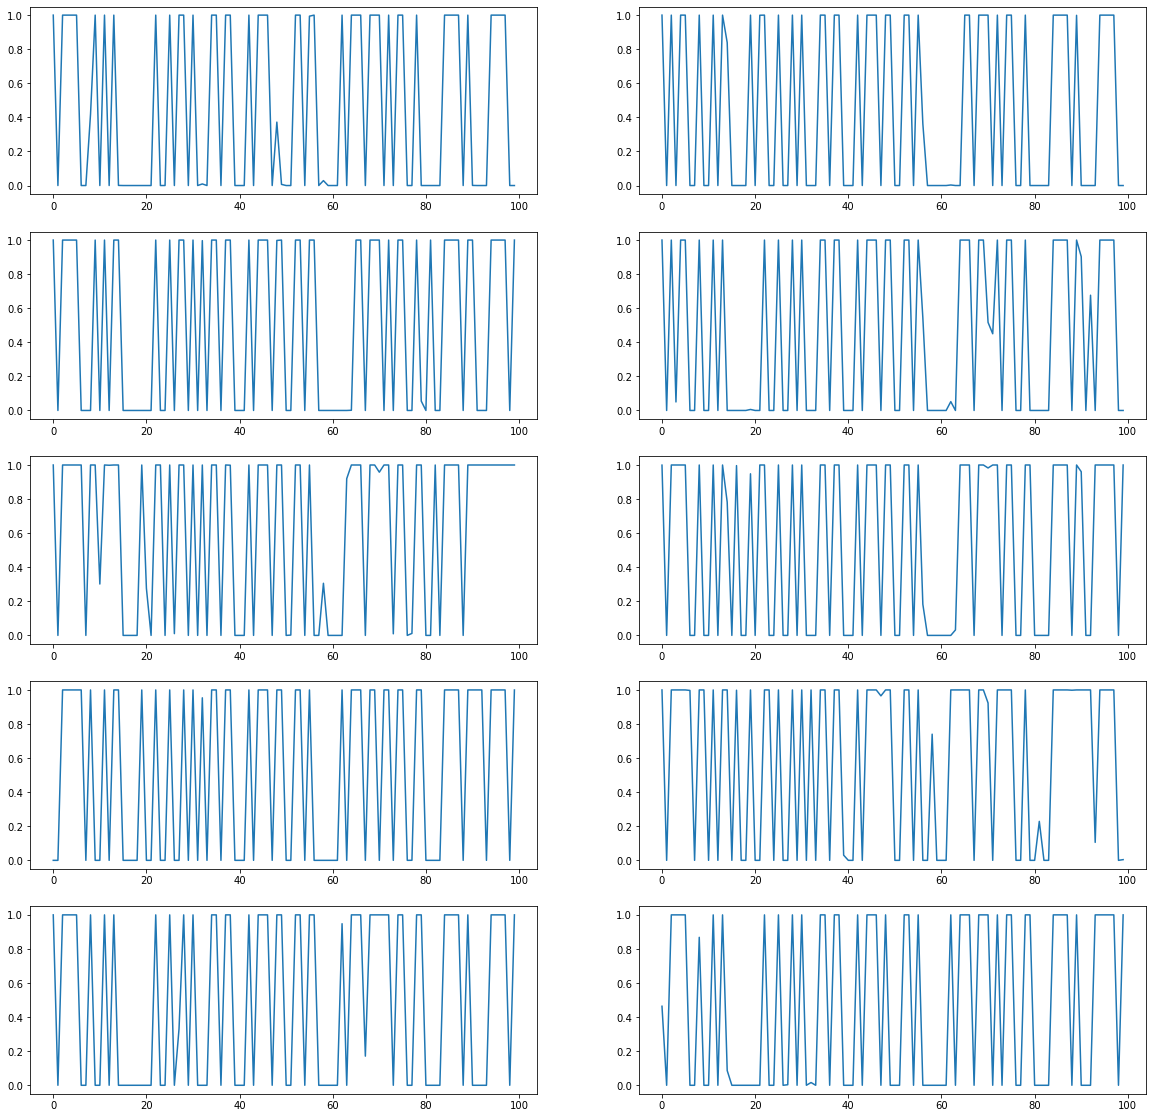

Prediction std: [0.478802   0.4552789  0.48437762 0.47590137 0.3601582  0.47769052
 0.44466817 0.2999373  0.48682493 0.48802945]


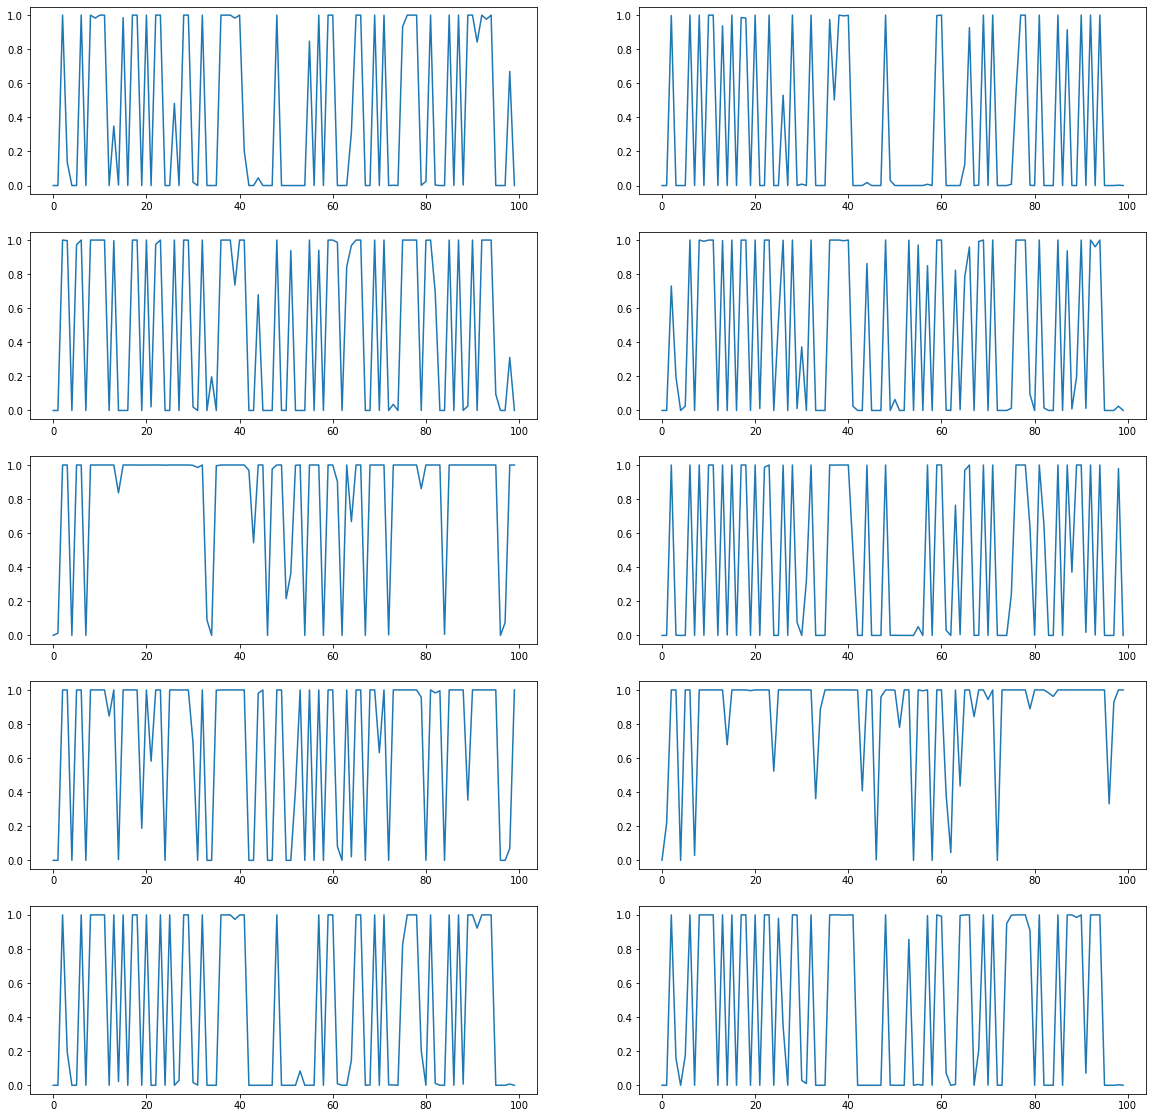

In [15]:
#plot the results for prior precision 10, 20, 50
net = NN(num_classes=2)
P = predict(net, W, test_10_X)
plot(P)

# Testing the model on other datasets

One of the hypothetical benefits of Bayesian Deep Learning is that a model is able to give you high uncertainty for out of distribution samples. Thereby the model essentially says "I don't know, I have never seen such an image before". In the following we have three out-of-distribution datasets for which we test whether this hypothesis holds. We first test on MNIST, then on a scaled version of FMNIST (i.e. every pixel value is multiplied by a thousand), and lastly we test on white noise (i.e. the pixel values are drawn from a standard Gaussian). The data has been prepared for you, you merely have to draw the weights, do the forward passes and plot the results similar to the previous exercise.

## test on MNIST

torch.Size([10, 1, 28, 28]) torch.Size([10])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


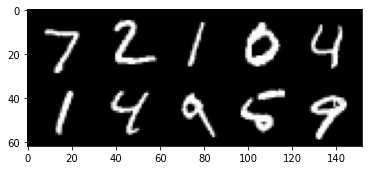

In [16]:
#set up Some MNIST images
MNIST_test = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=True,
        transform=FMNIST_transform)

mnist_test_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_test,
    batch_size=10,
    shuffle=False,
)

MNIST_test_10_X, MNIST_test_10_y = next(iter(mnist_test_loader))
print(MNIST_test_10_X.size(), MNIST_test_10_y.size())
print(MNIST_test_10_y)

MNIST_images = MNIST_test.data[:10].view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(MNIST_images, nrow=5))

Prediction std: [0.49956352 0.492969   0.49549812 0.49909723 0.49987763 0.49350798
 0.49996403 0.49970073 0.49491194 0.49892026]


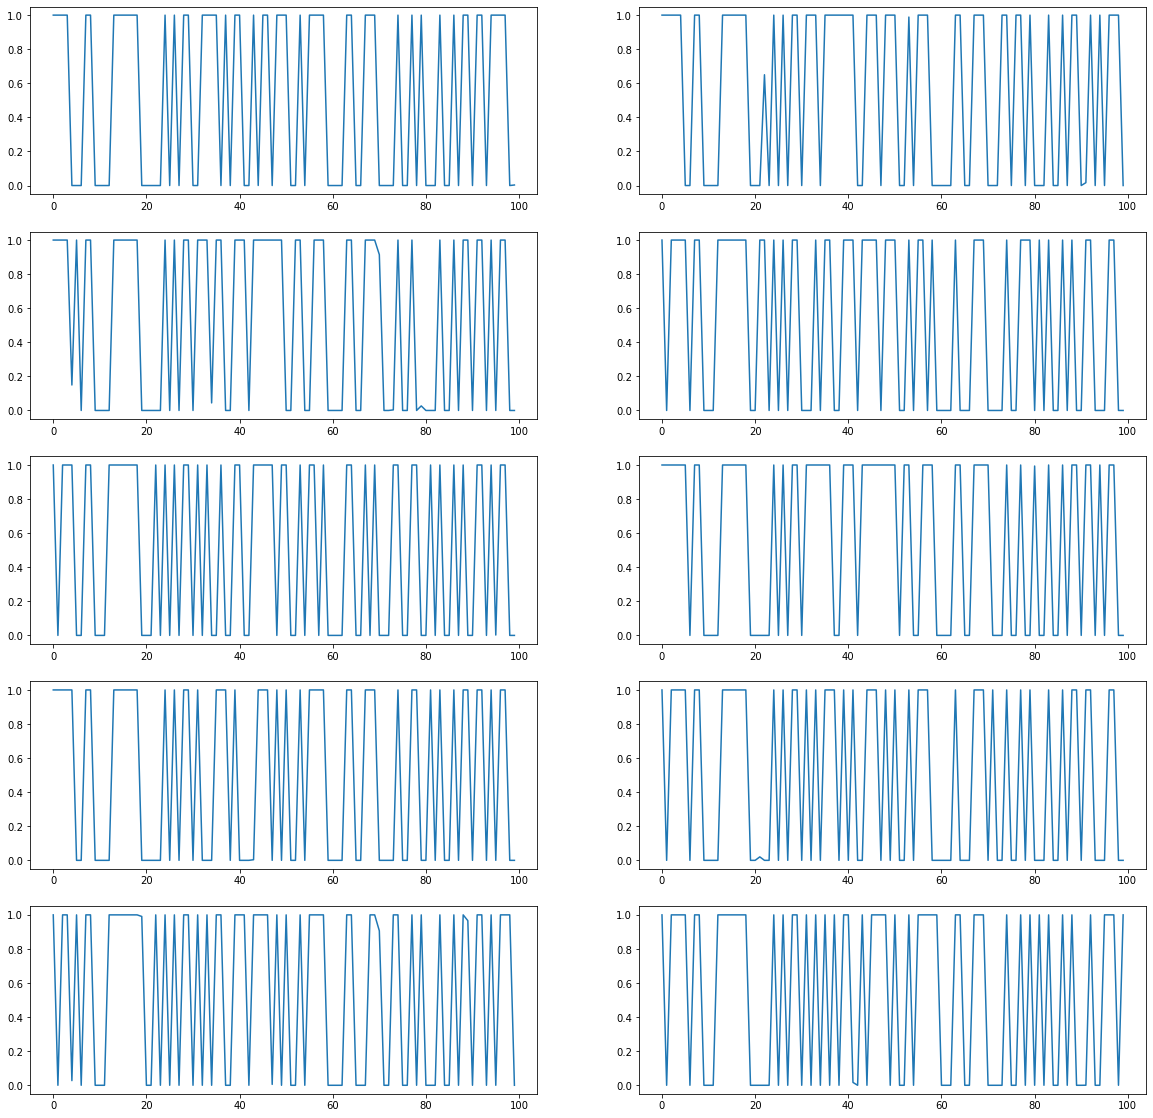

Prediction std: [0.46608216 0.47678444 0.46166015 0.4582903  0.4643683  0.46196726
 0.4794367  0.47235894 0.47818857 0.4734397 ]


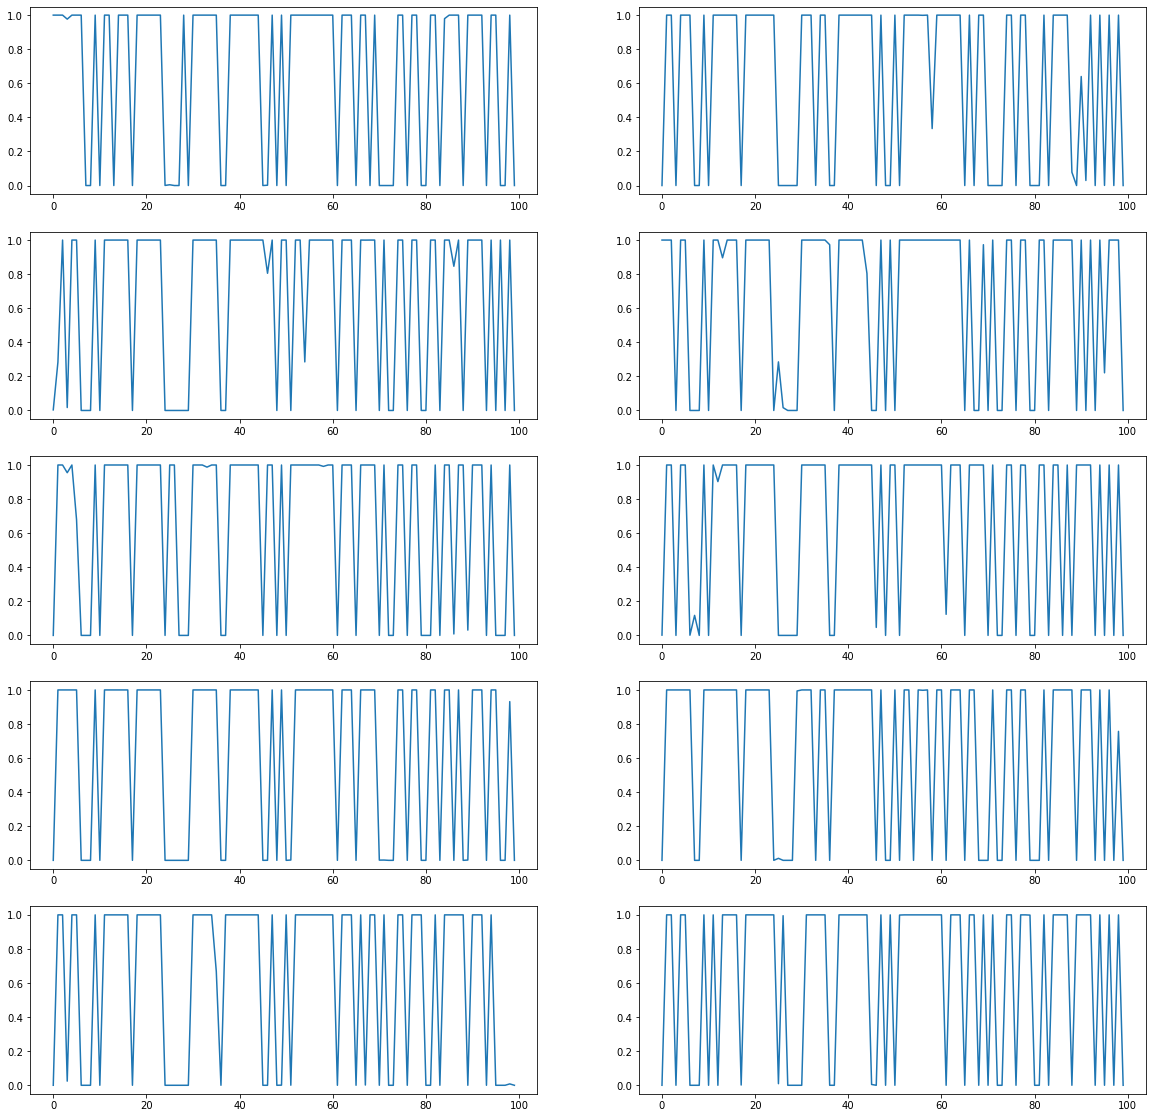

Prediction std: [0.47536016 0.46303985 0.46559063 0.47334775 0.47196513 0.44840088
 0.4147782  0.48385367 0.40331903 0.46155912]


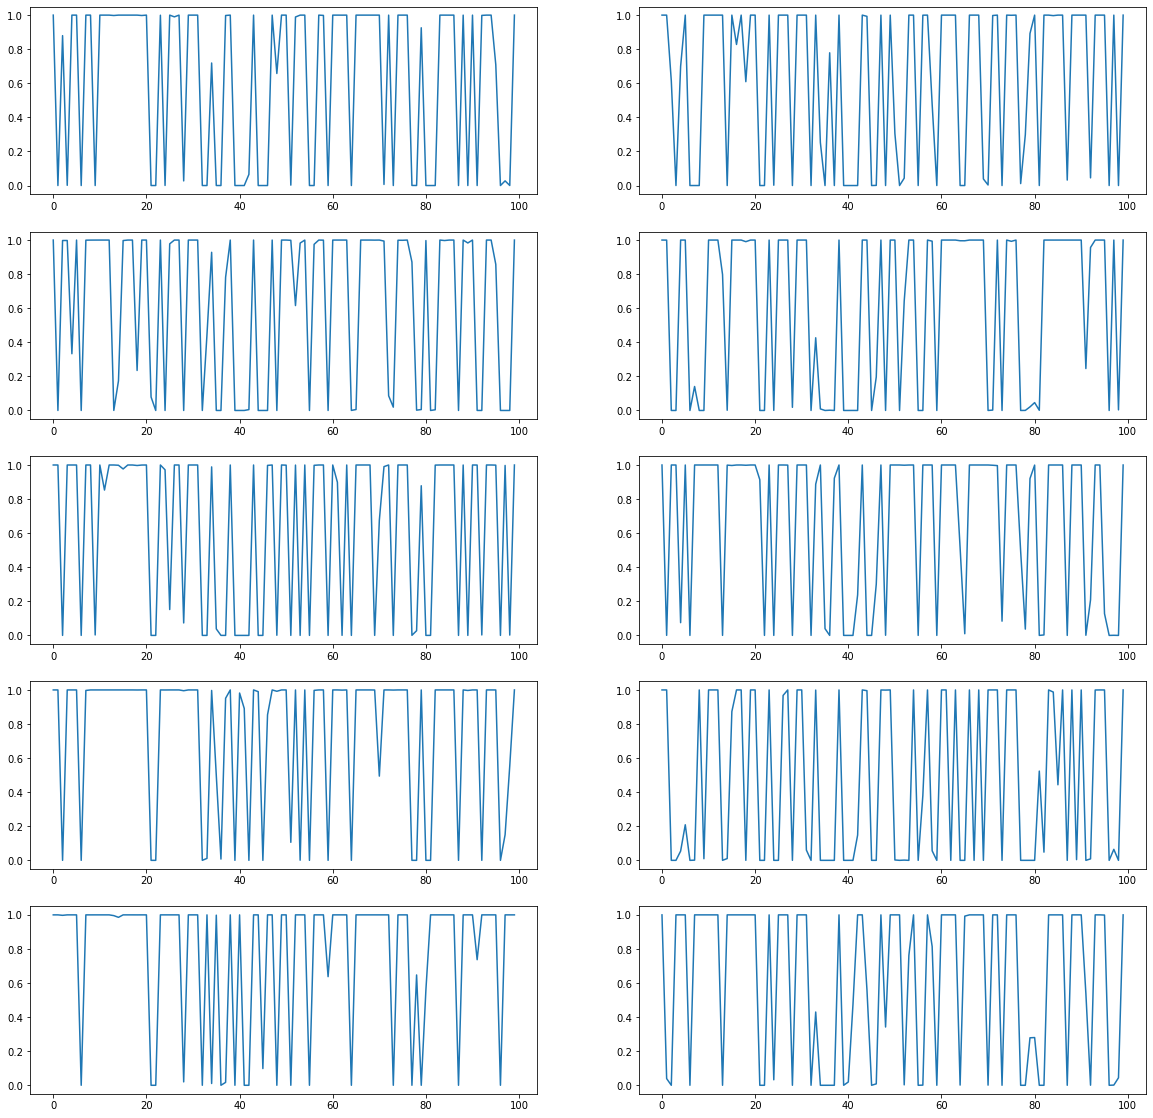

In [17]:
#plot the results for prior precision 10, 20, 50 on MNIST
W = [sample(fmnist_model, hess, n_samp=100) for hess in [hess10, hess20, hess50]]
net = NN(num_classes=2)
P = predict(net, W, MNIST_test_10_X)
plot(P)

## test on scaled FMNIST

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 1, 28, 28])


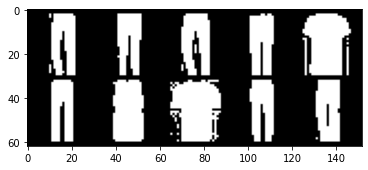

In [18]:
# set up some scaled FMNIST images
fmnist_test_loader_10 = torch.utils.data.dataloader.DataLoader(
    FMNIST_test,
    batch_size=10,
    shuffle=False,
)

FMNIST_test_10_X, FMNIST_test_10_y = next(iter(fmnist_test_loader_10))
FMNIST_test_10_X_scaled = 1000 * FMNIST_test_10_X
print(FMNIST_test_10_X_scaled.size())

FMNIST_images = FMNIST_test_10_X_scaled.view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(FMNIST_images, nrow=5))

Prediction std: [0.49909887 0.49959973 0.48538625 0.49355832 0.48989794 0.49959973
 0.4963869  0.48538625 0.4983973  0.49959973]


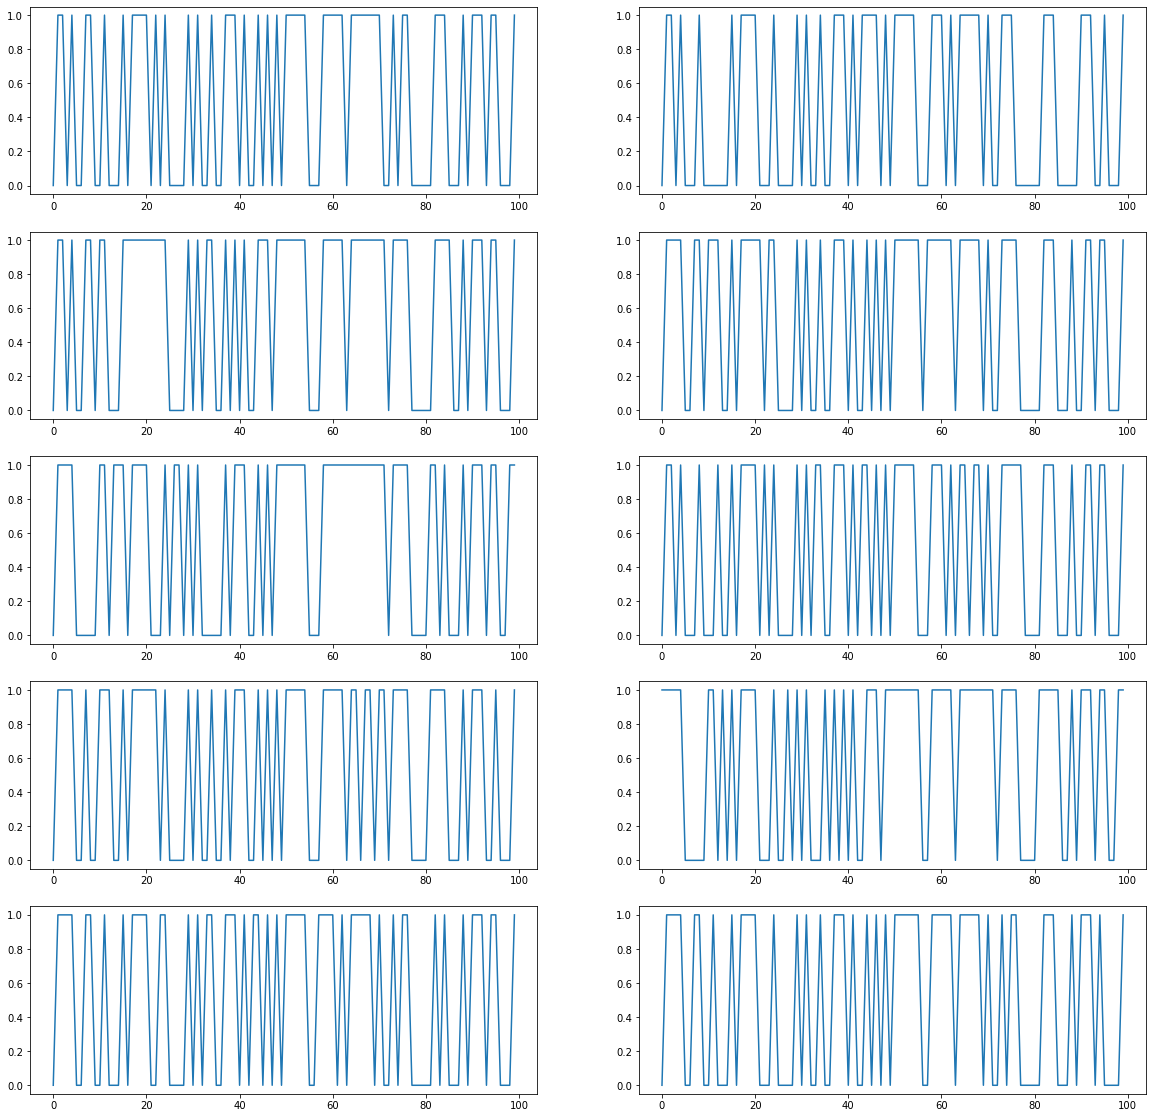

Prediction std: [0.49990007 0.4963869  0.4983973  0.49749357 0.47370887 0.4983973
 0.47999996 0.47370887 0.4974936  0.4983973 ]


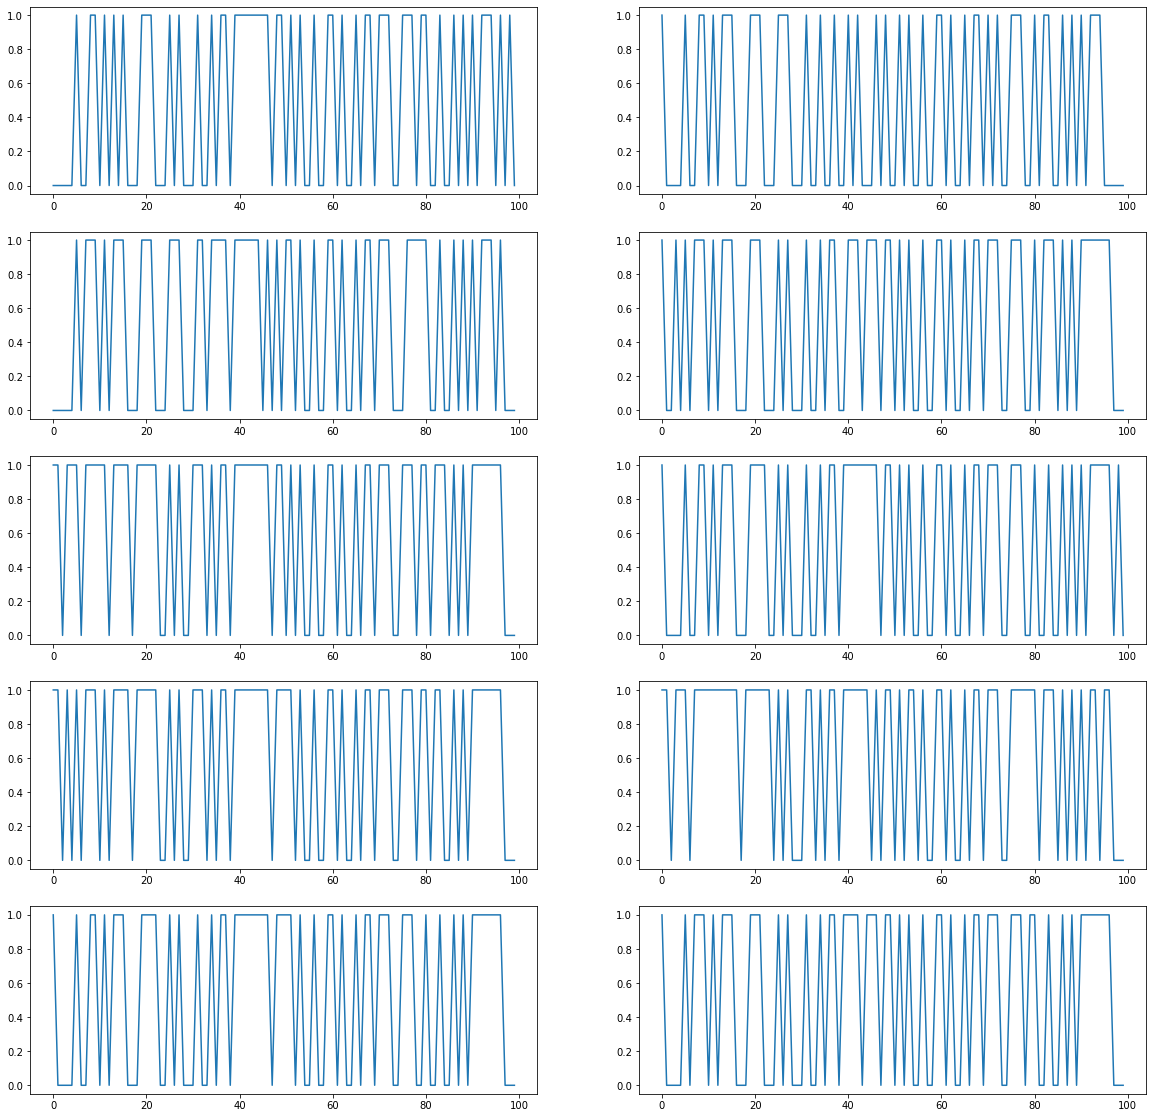

Prediction std: [0.4935586  0.4489988  0.4999001  0.4950757  0.30000016 0.49183348
 0.45825714 0.23748685 0.49839723 0.49749354]


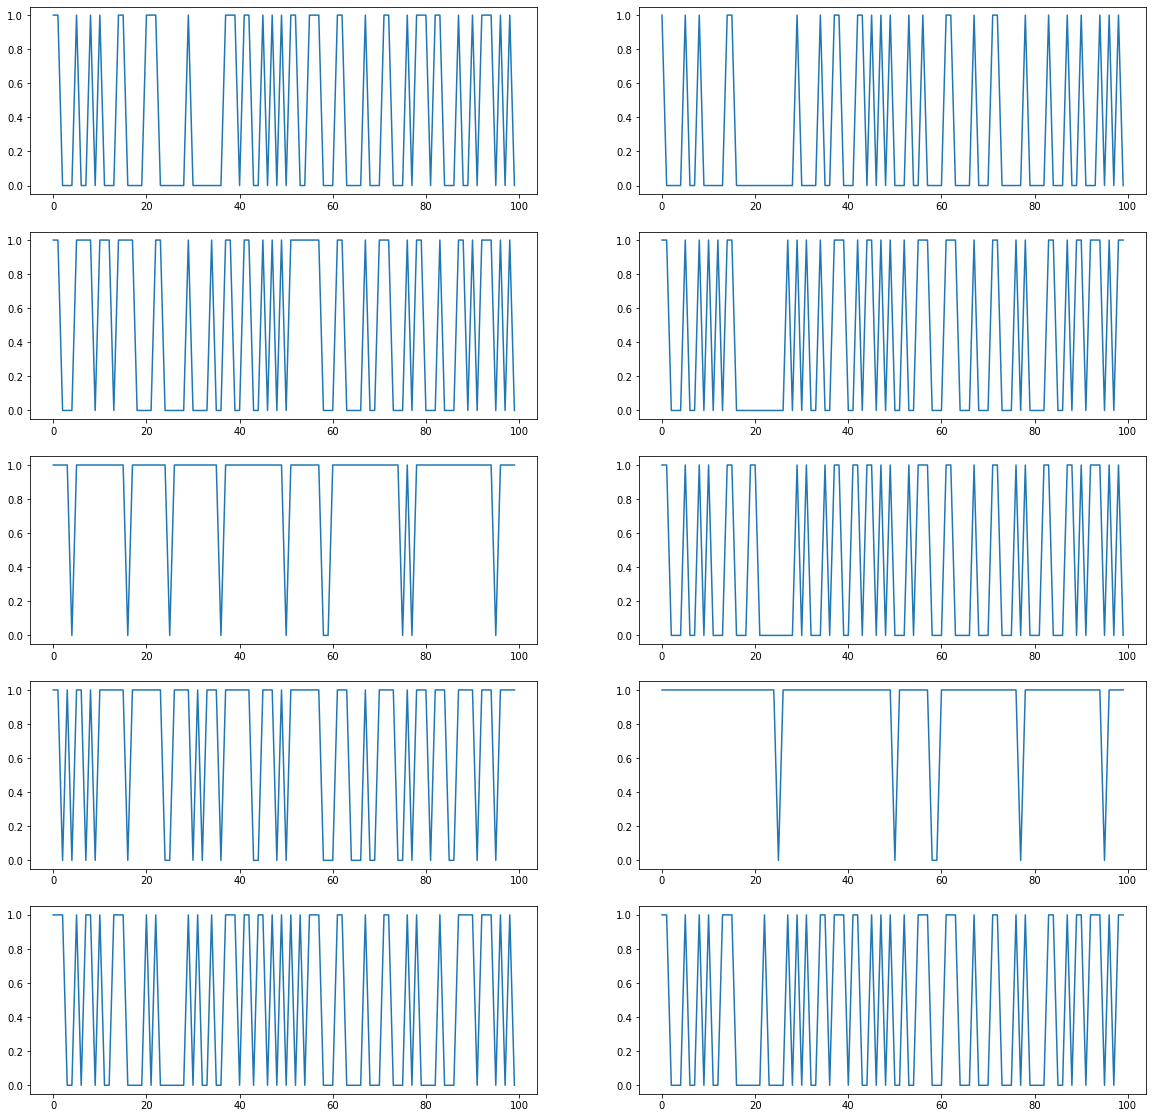

In [19]:
#plot the results for prior precision 10, 20, 50 on scaled FMNIST
W = [sample(fmnist_model, hess, n_samp=100) for hess in [hess10, hess20, hess50]]
net = NN(num_classes=2)
P = predict(net, W, FMNIST_test_10_X_scaled)
plot(P)

## test on white noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


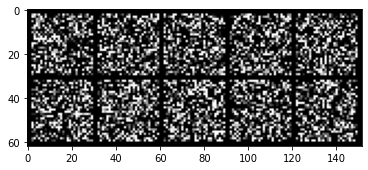

In [20]:
# set up some white noise images
white_noise_10 = torch.empty((10,1,28,28)).normal_(mean=0,std=1)
imshow(torchvision.utils.make_grid(white_noise_10, nrow=5))

Prediction std: [0.4877493  0.48838082 0.4918181  0.49183342 0.48774987 0.4882972
 0.49729133 0.49628884 0.49909887 0.4891834 ]


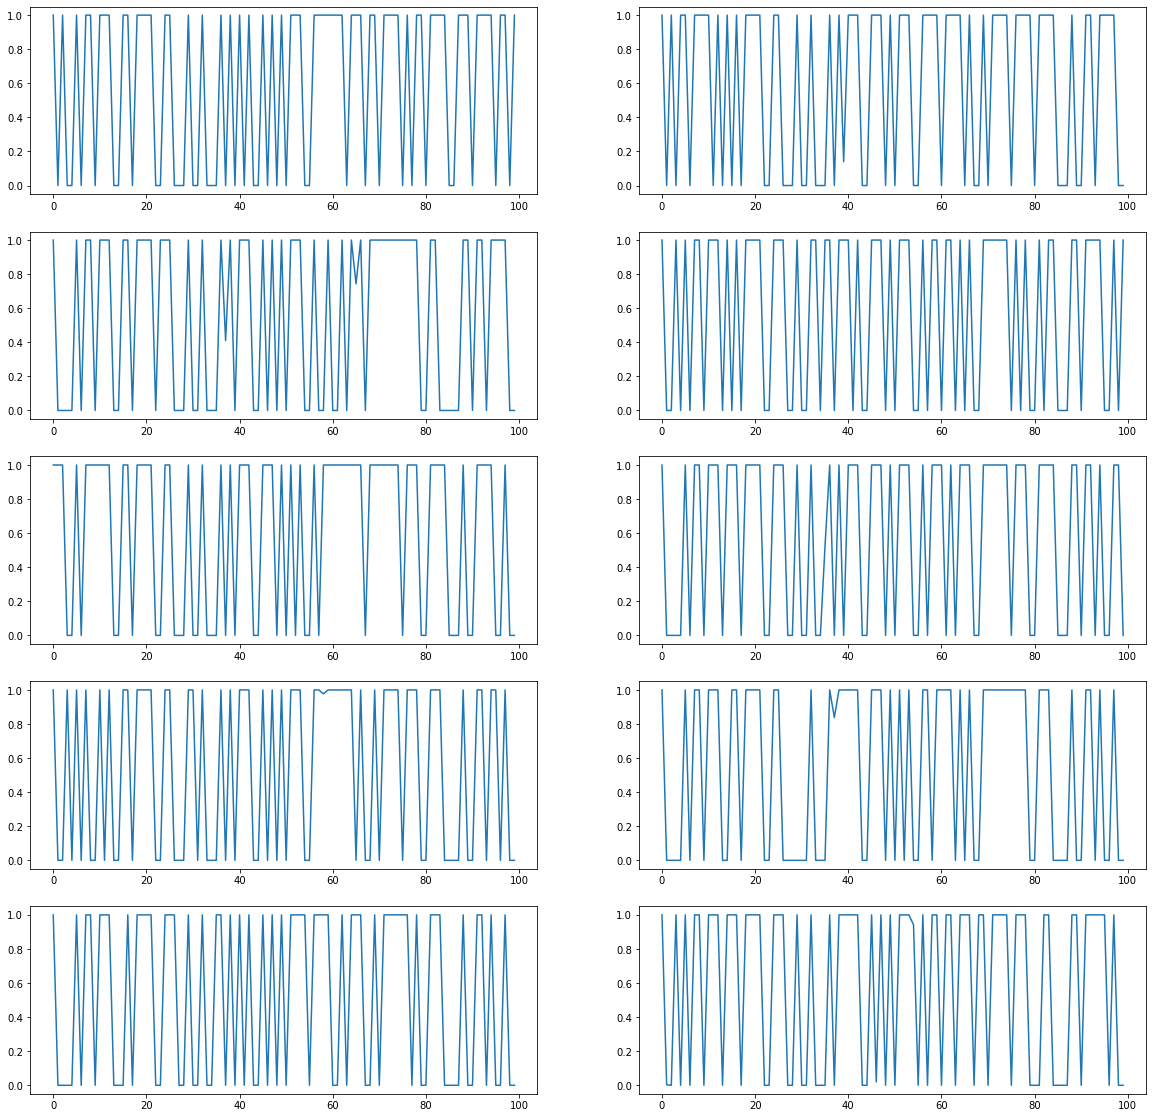

Prediction std: [0.49140465 0.48146957 0.48865876 0.47133705 0.49352887 0.4893775
 0.49812397 0.48128256 0.49145278 0.49341497]


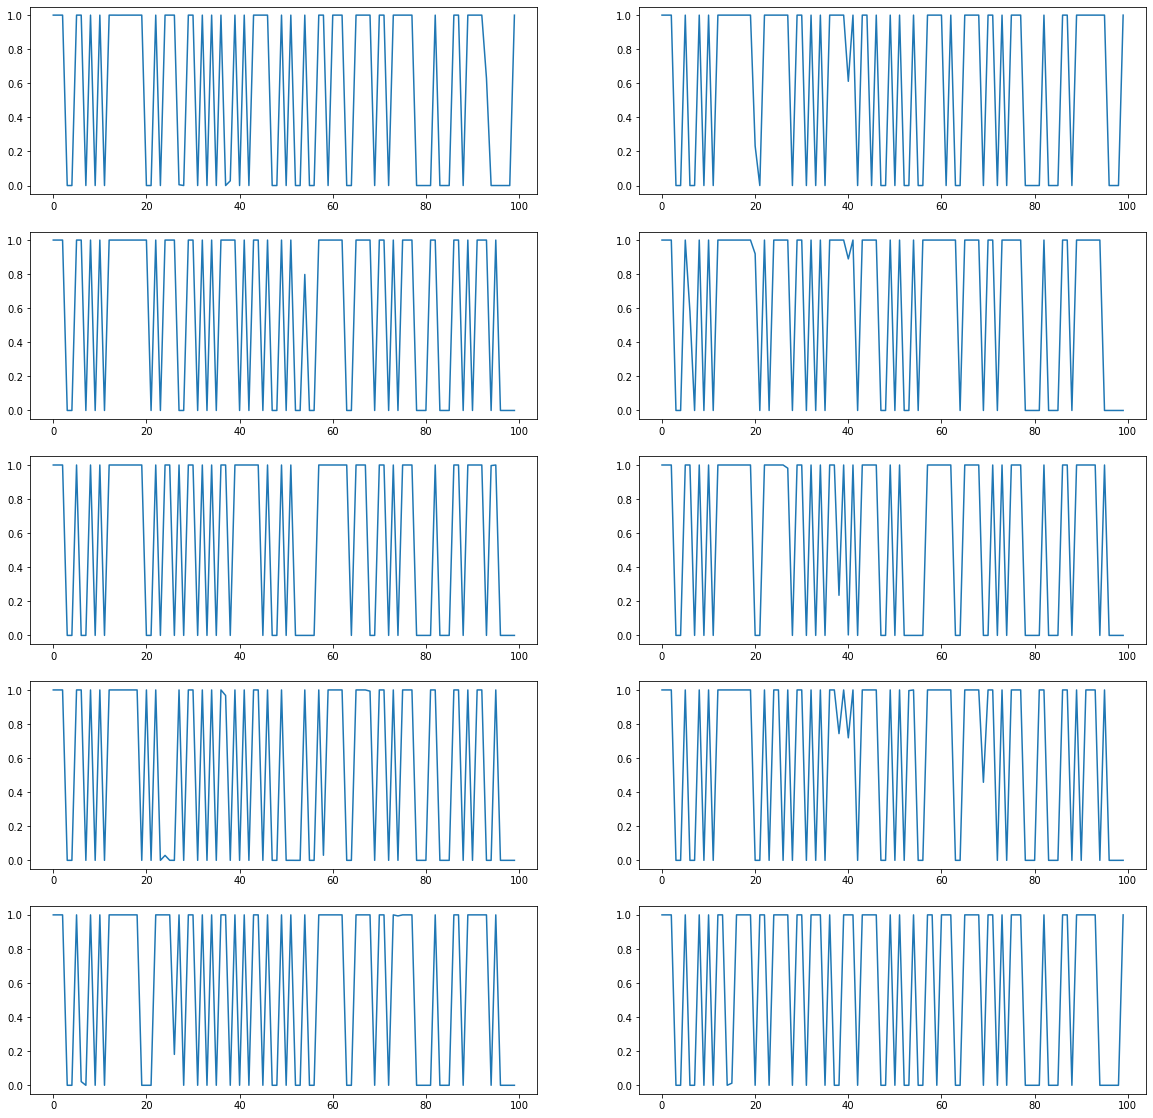

Prediction std: [0.41585037 0.37357226 0.45803487 0.3178928  0.4385088  0.42740774
 0.42921472 0.3840295  0.45962334 0.4120341 ]


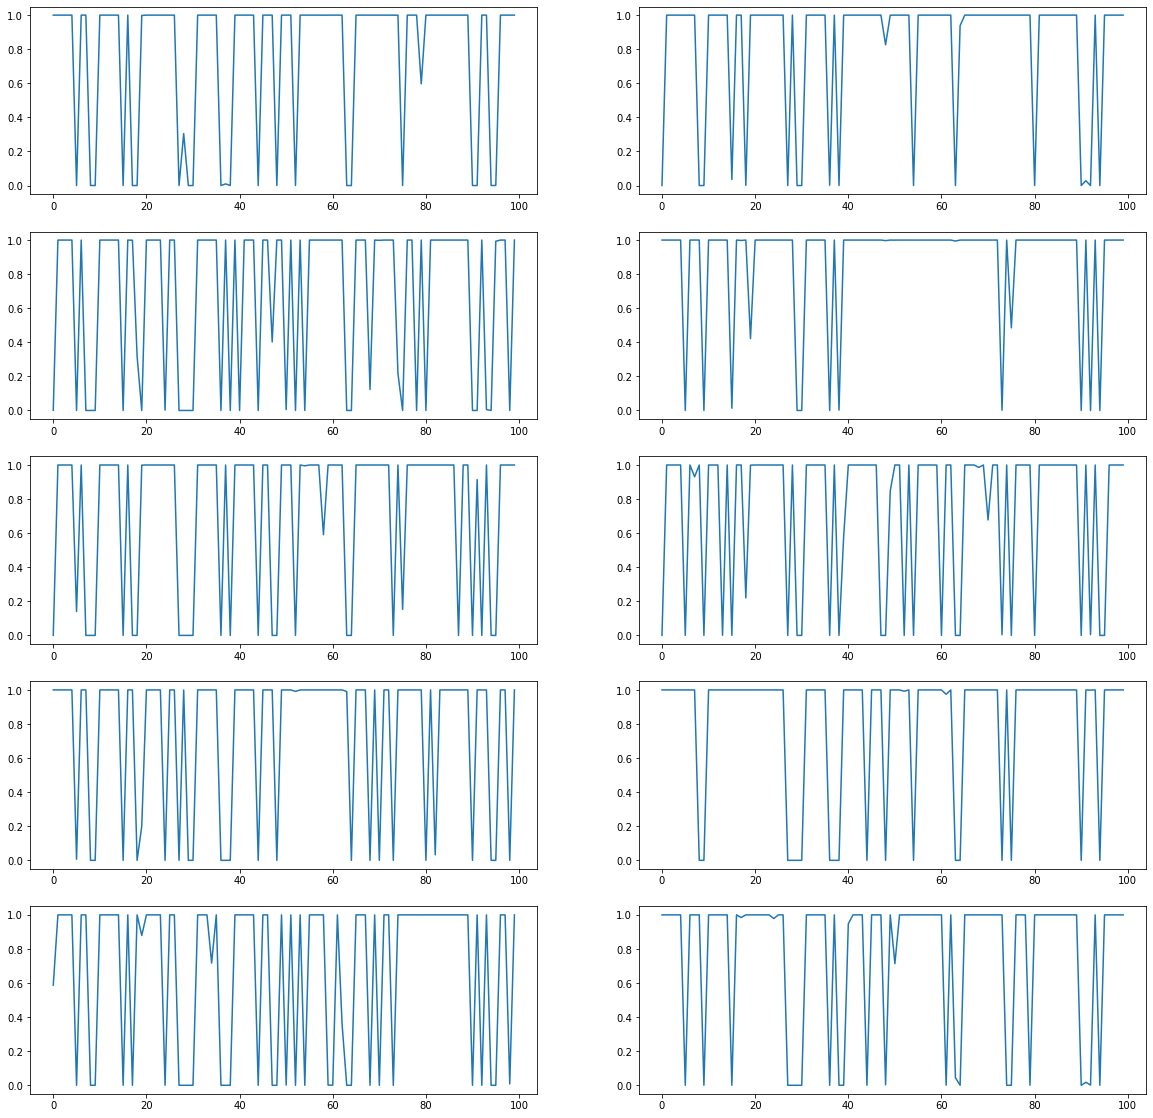

In [21]:
#plot the results for prior precision 10, 20, 50 on white noise
W = [sample(fmnist_model, hess, n_samp=100) for hess in [hess10, hess20, hess50]]
net = NN(num_classes=2)
P = predict(net, W, white_noise_10)
plot(P)

## What's your conclusion? (1 or 2 sentences are sufficient)

In [ ]:
#TODO